In [ ]:
import os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import wandb
from wandb.keras import WandbCallback

DATA_ROOT = "C:\\Users\\Student\\Desktop\\Kamilio\\Br35H"
IMG_SIZE = 128

## Load necessary functions

In [ ]:
import albumentations as A
AUTOTUNE = tf.data.AUTOTUNE
from functools import partial

transforms = A.Compose([
    A.HorizontalFlip(0.5),
    A.VerticalFlip(0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
])

def get_classes(dataset_name):
    #TODO add functionality to pop error if classes in data splits do not match
    class_names = os.listdir(os.path.join(DATA_ROOT, dataset_name, "train"))
    class_names.sort()
    return class_names

def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    # TODO: pass CLASS_NAMES as function parameter
    one_hot = parts[-2] == CLASS_NAMES
    # Integer encode the label
    return int(one_hot)

def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    return img

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    # Resize and norm the image
    aug_img = tf.image.resize(aug_img, size=[IMG_SIZE, IMG_SIZE])
    return aug_img

def apply_transformations(image):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img

def process_path(file_path, use_augmentations: bool):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    image = tf.io.read_file(file_path)
    image = decode_img(image)
    image = tf.cast(image/255, tf.float32)
    if use_augmentations:
        image = apply_transformations(image)
    return image, label

def load_dataset(dataset_name:str, split_type: str, use_transformations: bool, mini_batch_size: int):
    global CLASS_NAMES
    CLASS_NAMES = get_classes(dataset_name)
    dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\{dataset_name}\\{split_type}\\*\\*", shuffle=False)
    dataset = dataset.shuffle(len(dataset), reshuffle_each_iteration=False)
    dataset = dataset.map(partial(process_path, use_augmentations=use_transformations), num_parallel_calls=AUTOTUNE).batch(mini_batch_size)
    return dataset

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras import layers

def get_initial_weights_type(imagenet_pretrained_backbone: bool):
    if imagenet_pretrained_backbone:
        weights='imagenet'
    else:
        weights=None
    return weights

def rebuild_top(model, class_count: int):
    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization(name='batch_normalization')(x)
    outputs = layers.Dense(class_count, activation="softmax", name="pred")(x)
    return outputs

def build_EffNetB0(class_count: int, imagenet_pretrained_backbone: bool):
    
    weights_type = get_initial_weights_type(imagenet_pretrained_backbone)
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights=weights_type)
    outputs = rebuild_top(model, class_count)

    model = tf.keras.Model(inputs, outputs, name='EfficientNetB0')
    print("EffNet0 model build successfull")
    
    return model

def build_EffNetB3(class_count: int, imagenet_pretrained_backbone: bool):
    
    weights_type = get_initial_weights_type(imagenet_pretrained_backbone)
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB3(include_top=False, input_tensor=inputs, weights=weights_type)
    outputs = rebuild_top(model, class_count)

    model = tf.keras.Model(inputs, outputs, name='EfficientNetB3')
    print("EffNet3 model build successfull")
    
    return model

def build_EffNetB5(class_count: int, imagenet_pretrained_backbone: bool):
    
    weights_type = get_initial_weights_type(imagenet_pretrained_backbone)
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB5(include_top=False, input_tensor=inputs, weights=weights_type)
    outputs = rebuild_top(model, class_count)

    model = tf.keras.Model(inputs, outputs, name='EfficientNetB5')
    print("EffNet5 model build successfull")
    
    return model

def build_model(class_count: int, imagenet_pretrained_backbone: bool, architecture: str):
    if architecture == "EffNetB0":
        model = build_EffNetB0(class_count, imagenet_pretrained_backbone)
    elif architecture == "EffNetB3":
        model = build_EffNetB3(class_count, imagenet_pretrained_backbone)
    elif architecture == "EffNetB5":
        model = build_EffNetB5(class_count, imagenet_pretrained_backbone)
    else:
        raise Exception(f"Specified model architecture is not available")
        
    return model
        

## Visiaulize samples from pre-text dataset

In [10]:
# class_names = os.listdir(os.path.join(DATA_ROOT, DATASET_SSL,'train'))

# rot_train_dataset_eg = tf.data.Dataset.list_files(f"{DATA_ROOT}\\{DATASET_SSL}\\train\\*\\*", shuffle=False)
# rot_train_dataset_eg = rot_train_dataset_eg.shuffle(len(rot_train_dataset_eg), reshuffle_each_iteration=False)
# rot_train_dataset_eg = rot_train_dataset_eg.map(process_path, num_parallel_calls=AUTOTUNE).batch(1)

In [13]:
# iterator=iter(rot_train_dataset_eg)

# for _ in range(500):
#     sample = next(iterator)
#     image = sample[0].numpy().reshape(IMG_SIZE,IMG_SIZE,3)
#     label = tf.math.argmax(sample[1], axis=1).numpy()[0]
#     SAMPLE_DICT[str(label)].append(image)

IndexError: list index out of range

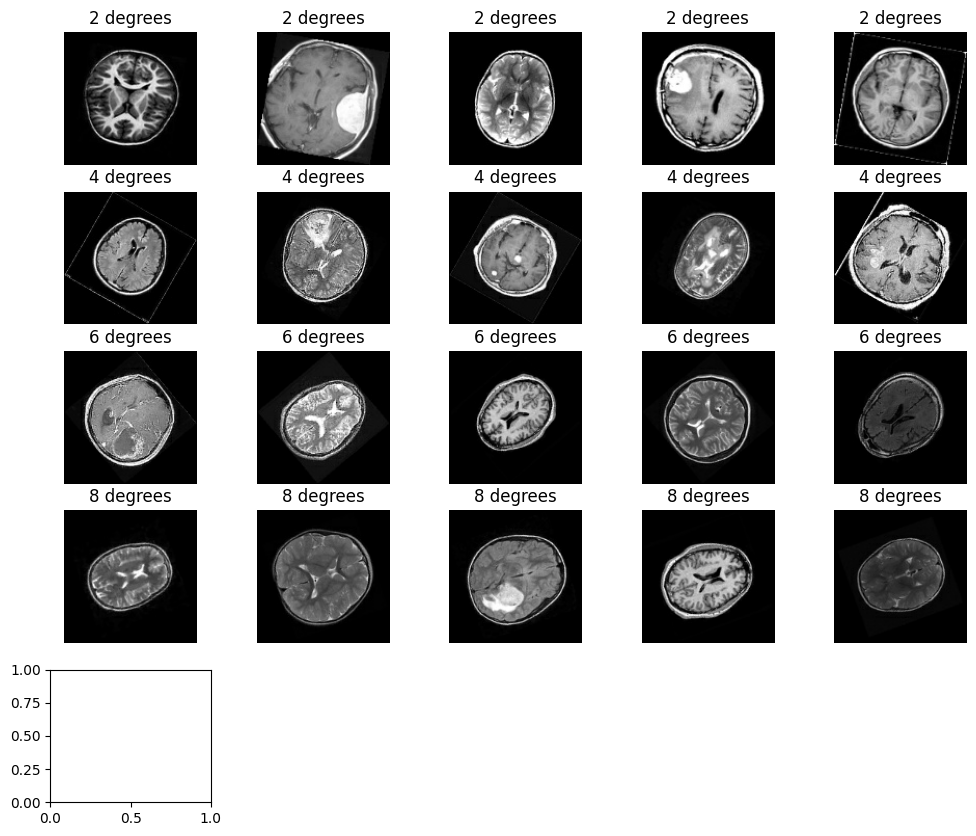

In [14]:
# class_count = len(SAMPLE_DICT)
# plt.figure(figsize=(12,10))
# i=1
# for row in range(class_count):
#     for column in range(5):
#         plt.subplot(class_count, 5, i)
#         image = SAMPLE_DICT[str(row)][column]
#         rot_angle = MAP_DICT[str(row)]
#         plt.imshow(image)
#         plt.title(f'{rot_angle} degrees')
#         plt.axis('off')
#         i += 1

## Visiaulize samples from downstream taskdataset

In [15]:
# class_names = os.listdir(os.path.join(DATA_ROOT, DATASET_FINE_TUNE,'train'))
# map_dict = {'0': 'non-tumorous', '1': 'tumorous'}
# sample_dict = {'0': [], '1': []}

# train_dataset_eg = tf.data.Dataset.list_files(f"{DATA_ROOT}\\{DATASET_FINE_TUNE}\\train\\*\\*", shuffle=False)
# train_dataset_eg = train_dataset_eg.shuffle(len(train_dataset_eg), reshuffle_each_iteration=False)
# train_dataset_eg = train_dataset_eg.map(partial(process_path, use_augmentations=True), num_parallel_calls=AUTOTUNE).batch(1)

In [18]:
# iterator=iter(train_dataset_eg)

# for _ in range(500):
#     sample = next(iterator)
#     image = sample[0].numpy().reshape(IMG_SIZE,IMG_SIZE,3)
#     label = tf.math.argmax(sample[1], axis=1).numpy()[0]
#     sample_dict[str(label)].append(image)

NameError: name 'sample_dict' is not defined

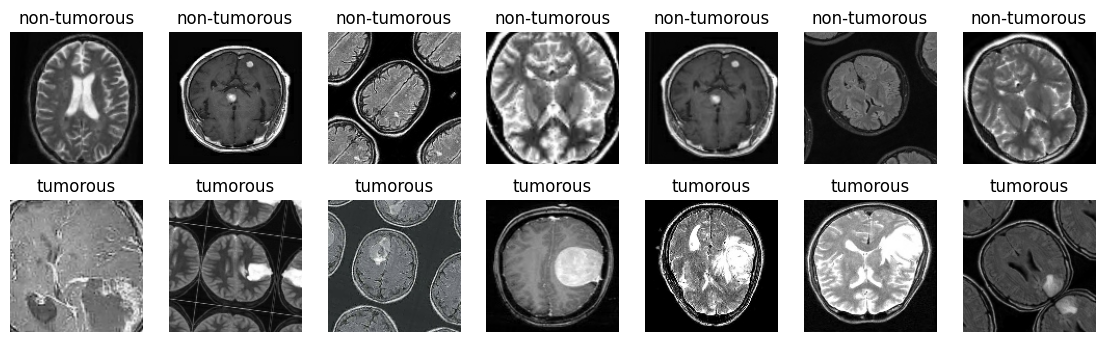

In [17]:
# class_count = len(sample_dict)
# plt.figure(figsize=(14,4))
# i=1
# for row in range(class_count):
#     for column in range(7):
#         plt.subplot(class_count, 7, i)
#         image = sample_dict[str(row)][column]
#         classs = map_dict[str(row)]
#         plt.imshow(image)
#         plt.title(f'{classs}')
#         plt.axis('off')
#         i += 1

## Load datasets

## Train model for rotation angle classifiction pre-text task

In [ ]:
model_name = "model_v1.8.0"

run = wandb.init(entity = 'ssl_bakalauras',
                 project="SSL_rotation_angle_classification",
                 name = model_name,
                 config={
                     "type": "SSL",
                     "task": "rotation angle classification",
                     "dataset_origin": "Br35H",
                     "dataset_name": "data_v1.4.0",
                     "architecture": "EffNetB5",
                     "imagenet_pretrained_backbone": False,
                     "use_transformations": False,
                     "loss_function": "categorical_crossentropy",
                     "metrics": ['acc'],
                     "learning_rate": 0.001,
                     "batch_size": 32,
                     "epochs": 100
                     })

config = wandb.config
project_name = run.project

print(config)
print(f"\nModel version: {model_name}\n")
print(f"{config.architecture} architecture will be used")

tf.keras.backend.clear_session()

class_names = get_classes(config.dataset_name)
print(f"\nClasses: {class_names}\n")
if config.use_transformations:
    transformations = str(transforms)
    print(f"Using transfromations for train dataset:{architectures[str(minor)]}")
else:
    transformations = None
    print(f"No transformations will be used")
        

wandb.log({
    "class_names": class_names,
    "transformations": transformations
})

train_ds = load_dataset(
                      dataset_name = config.dataset_name, 
                      split_type = "train", 
                      use_transformations = config.use_transformations, 
                      mini_batch_size = config.batch_size)

val_ds = load_dataset(
                      dataset_name = config.dataset_name, 
                      split_type = "val", 
                      use_transformations = config.use_transformations, 
                      mini_batch_size = config.batch_size)

# Initialize model

model = build_model(
                    class_count = len(class_names), 
                    imagenet_pretrained_backbone = config.imagenet_pretrained_backbone,
                    architecture = config.architecture)

print(f"Successfully initialized {config.architecture} model from scratch")


# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
model.compile(optimizer=optimizer, loss=config.loss_function, metrics = config.metrics)

model.fit(train_ds,
          epochs=config.epochs,
          validation_data=val_ds,
          callbacks=[WandbCallback(save_model=(False))])

model.save(f"C:\\Users\\Student\\Desktop\\Kamilio\\models\\{project_name}\\{model_name}")

run.finish()

## Fine-tune pretrained model for brain tumor classification task

In [ ]:
config1={
     "type": "Downstream",
     "task": "rotation angle classification",
     "dataset_origin": "Br35H",
     "dataset_name": "data_v1.0.0",
     "use_transformations": False,
     "frozen_backbone": False,
     "loss_function": "categorical_crossentropy",
     "learning_rate": 0.001,
     "batch_size": 32,
     "epochs": 250}
    
config2={
     "type": "Downstream",
     "task": "rotation angle classification",
     "dataset_origin": "Br35H",
     "dataset_name": "data_v1.0.0",
     "use_transformations": False,
     "frozen_backbone": True,
     "loss_function": "categorical_crossentropy",
     "learning_rate": 0.001,
     "batch_size": 32,
     "epochs": 250}

config3={
     "type": "Downstream",
     "task": "rotation angle classification",
     "dataset_origin": "Br35H",
     "dataset_name": "data_v1.0.0",
     "use_transformations": True,
     "frozen_backbone": False,
     "loss_function": "categorical_crossentropy",
     "learning_rate": 0.001,
     "batch_size": 32,
     "epochs": 250}

config4={
     "type": "Downstream",
     "task": "rotation angle classification",
     "dataset_origin": "Br35H",
     "dataset_name": "data_v1.0.0",
     "use_transformations": True,
     "frozen_backbone": True,
     "loss_function": "categorical_crossentropy",
     "learning_rate": 0.001,
     "batch_size": 32,
     "epochs": 250}

configs = {"0": config3, "1": config1, "2": config2, "3": config3, "4": config4}

architectures = {"0": "EffNetB0", "1": "EffNetB0", "2": "EffNetB0", "3": "EffNetB0", "4": "EffNetB0",
                 "5": "EffNetB3", "6": "EffNetB3", "7": "EffNetB5", "8": "EffNetB5"}
initial_weigths = {"ImageNet": [0, 5, 7], "Pre-text": [1, 2, 3, 4, 6, 8]}

In [ ]:
for minor in [0, 1, 2, 3, 4, 5, 6, 7, 8]:  
    for micro in [0, 1, 2, 3, 4]:
        
        # Skip training if minor version is accosiated with SSL model and downstream model is trained from scratch
        if minor in initial_weigths["Pre-text"] and micro == 0:
            continue
        
        model_name = f"model_v1.{str(minor)}.{str(micro)}"

        run = wandb.init(entity = 'ssl_bakalauras',
                         project="Downstream_v1",
                         name = model_name,
                         config = configs[str(micro)])

        print(configs[str(micro)])
        print(f"\nModel version: {model_name}\n")
        print(f"{architectures[str(minor)]} architecture will be used")
        config = wandb.config
        project_name = run.project

        tf.keras.backend.clear_session()

        class_names = get_classes(config.dataset_name)
        print(f"\nClasses: {class_names}\n")
        if config.use_transformations:
            transformations = str(transforms)
            print(f"Using transfromations for train dataset:\n{transformations}\n")
        else:
            transformations = None
            print(f"No transformations will be used")

# Load datasets
        
        train_ds = load_dataset(
                              dataset_name = config.dataset_name, 
                              split_type = "train", 
                              use_transformations = config.use_transformations, 
                              mini_batch_size = config.batch_size)

        val_ds = load_dataset(
                              dataset_name = config.dataset_name, 
                              split_type = "val", 
                              use_transformations = False, 
                              mini_batch_size = config.batch_size)

        test_ds = load_dataset(
                              dataset_name = config.dataset_name, 
                              split_type = "test", 
                              use_transformations = False, 
                              mini_batch_size = config.batch_size)
# Initialize model

        if minor in initial_weigths["ImageNet"] and micro == 0:
            upstream_model_name = f"None"
            model = build_model(
                            class_count = len(class_names), 
                            imagenet_pretrained_backbone = False,
                            architecture = architectures[str(minor)])
            print(f"Successfully initialized {architectures[str(minor)]} model from scratch")
        elif minor in initial_weigths["ImageNet"] and micro !=0:
            upstream_model_name = f"ImageNet"
            model = build_model(
                            class_count = len(class_names), 
                            imagenet_pretrained_backbone = True,
                            architecture = architectures[str(minor)])
            print(f"Succesfully loaded weights of ImageNet pretrained {architectures[str(minor)]} model as initial weights")
        elif minor in initial_weigths["Pre-text"]:
            upstream_model_name = f"model_v1.{str(minor)}.0"
            model = tf.keras.models.load_model(f"C:\\Users\\Student\\Desktop\\Kamilio\\models\\SSL_rotation_angle_classification\\{upstream_model_name}")
            # Reinitializing dense classification layer
            inputs = model.input
            x = model.layers[-4].output
            x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
            x = layers.BatchNormalization(name='batch_normalization')(x)
            outputs = layers.Dense(len(class_names), activation="softmax", name="pred")(x)

            model = tf.keras.Model(inputs, outputs, name=architectures[str(minor)])
            print(f"Succesfully loaded weights of SSL {upstream_model_name} model as initial weights")
        else:
            raise Exception("Failed to load upstream model")

        wandb.log({
            "architecture": architectures[str(minor)],
            "class_names": class_names,
            "transformations": transformations,
            "initial_weights": upstream_model_name
        })
        
        # Freezing the Convolutional Layers while keeping Dense layers as Trainable
        if config.frozen_backbone:
            for layer in model.layers:
                if not (layer.name in ['pred', 'batch_normalization']):
                    layer.trainable=False
                else:
                    layer.trainable=True
            print("Model backbone layers were frozen successfully\n")
        else:
            print("None of the model layers are frozen\n")

# Compile model
        optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
        model.compile(optimizer=optimizer, loss=config.loss_function, metrics = ['acc', tf.keras.metrics.AUC()])

# Train the model        
        
        model.fit(train_ds,
                  epochs=config.epochs,
                  validation_data=val_ds,
                  callbacks=[WandbCallback(save_model=(False))])
        
# Test the model         
        
        test_loss, test_acc, test_auc = model.evaluate(test_ds)
        wandb.log({
                "test_loss": test_loss,
                "test_acc": test_acc,
                "test_auc": test_auc
        })

# Save the model    

        if minor in initial_weigths["ImageNet"]:
            model.save_weights(f"C:\\Users\\Student\\Desktop\\Kamilio\\models\\{project_name}\\{model_name}\\checkpoint")
        elif minor in initial_weigths["Pre-text"]:
            model.save(f"C:\\Users\\Student\\Desktop\\Kamilio\\models\\{project_name}\\{model_name}")

        run.finish()